In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.spatial import KDTree
from scipy.sparse.csgraph import minimum_spanning_tree

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 50 - 1890-02-16 to 1890-02-22.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Combine global and filtered local maxima coordinates for clustering
all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

# Perform K-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(all_maxima_coords)

# Initialize dictionaries to store points for each cluster
clusters = {0: [], 1: []}

# Sort points into their respective clusters
for label, point in zip(cluster_labels, all_maxima_coords):
    clusters[label].append(point)

# Plotting code continues here
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='gray', edgecolor='none')

# Function to connect points within each cluster using Minimum Spanning Tree
def connect_points_within_cluster(points, ax, color):
    if len(points) < 2:
        return
    # Compute the distance matrix
    distance_matrix = cdist(points, points)
    # Compute the MST using the distance matrix
    mst = minimum_spanning_tree(distance_matrix).toarray()
    # Plot the MST
    for i in range(len(points)):
        for j in range(len(points)):
            if mst[i, j] > 0:
                ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

# Plot points and lines for each cluster
for cluster_idx in clusters:
    cluster_points = clusters[cluster_idx]
    
    # Plot points
    if cluster_idx == 0:
        color = 'red'
    else:
        color = 'blue'
    
    for x, y in cluster_points:
        ax.plot(x, y, marker='o', color=color, markersize=10)
    
    # Connect points within the cluster using MST
    connect_points_within_cluster(cluster_points, ax, color)

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clustered Maxima and Lines for Rainfall Events')

plt.show()


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_8882/2200302625.py:7: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter


Cluster 1 direction: North-west to South-east
Cluster 2 direction: South-west to North-east


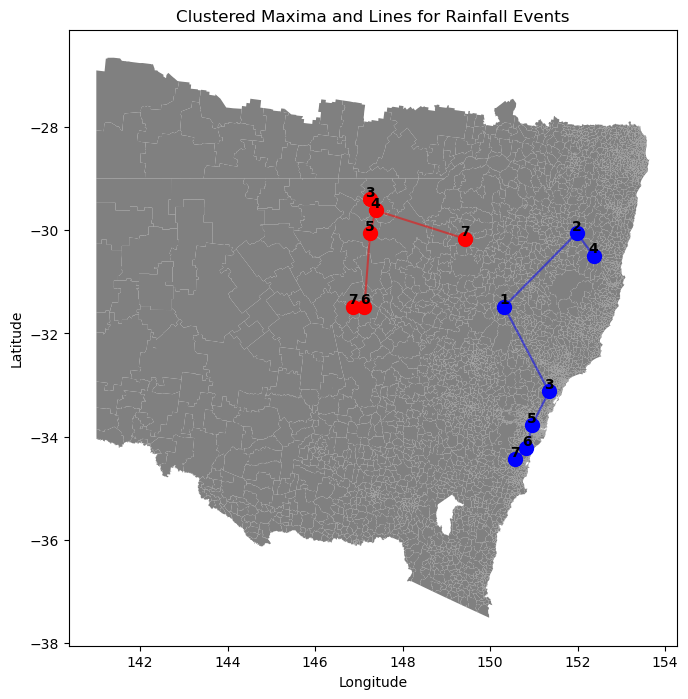

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.spatial import KDTree
from scipy.sparse.csgraph import minimum_spanning_tree

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 50 - 1890-02-16 to 1890-02-22.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Combine global and filtered local maxima coordinates for clustering
all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

# Perform K-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(all_maxima_coords)

# Initialize dictionaries to store points for each cluster
clusters = {0: [], 1: []}

# Sort points into their respective clusters
for label, point in zip(cluster_labels, all_maxima_coords):
    clusters[label].append(point)

# Function to determine the direction category
def categorize_direction(angle):
    if -15 <= angle <= 15:
        return 'East-West'
    elif 15 < angle <= 75:
        return 'North-east to South-west'
    elif 75 < angle <= 105:
        return 'North-South'
    elif 105 < angle <= 165:
        return 'North-west to South-east'
    elif angle > 165 or angle <= -165:
        return 'West-East'
    elif -75 <= angle < -15:
        return 'South-east to North-west'
    elif -105 <= angle < -75:
        return 'South-North'
    elif -165 <= angle < -105:
        return 'South-west to North-east'
    else:
        return 'Undefined'

# Determine the overall direction for each cluster
overall_directions = {}

for cluster_idx in clusters:
    cluster_points = clusters[cluster_idx]
    if len(cluster_points) >= 2:
        first_point = cluster_points[0]
        last_point = cluster_points[-1]
        dx = first_point[0] - last_point[0]
        dy = first_point[1] - last_point[1]
        angle = np.degrees(np.arctan2(dy, dx))
        direction = categorize_direction(angle)
        overall_directions[cluster_idx] = direction
    else:
        overall_directions[cluster_idx] = 'Undefined'

# Print the direction for each cluster
for cluster_idx, direction in overall_directions.items():
    print(f'Cluster {cluster_idx + 1} direction: {direction}')

# Plotting code continues here
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='gray', edgecolor='none')

# Function to connect points within each cluster using Minimum Spanning Tree
def connect_points_within_cluster(points, ax, color):
    if len(points) < 2:
        return
    # Compute the distance matrix
    distance_matrix = cdist(points, points)
    # Compute the MST using the distance matrix
    mst = minimum_spanning_tree(distance_matrix).toarray()
    # Plot the MST
    for i in range(len(points)):
        for j in range(len(points)):
            if mst[i, j] > 0:
                ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

# Plot points and lines for each cluster
for cluster_idx in clusters:
    cluster_points = clusters[cluster_idx]
    
    # Plot points
    if cluster_idx == 0:
        color = 'red'
    else:
        color = 'blue'
    
    for x, y in cluster_points:
        ax.plot(x, y, marker='o', color=color, markersize=10)
    
    # Connect points within the cluster using MST
    connect_points_within_cluster(cluster_points, ax, color)

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clustered Maxima and Lines for Rainfall Events')

plt.show()


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_8882/2884455095.py:7: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter


Cluster 1 weighted direction: North-west to South-east
Cluster 2 weighted direction: South-North


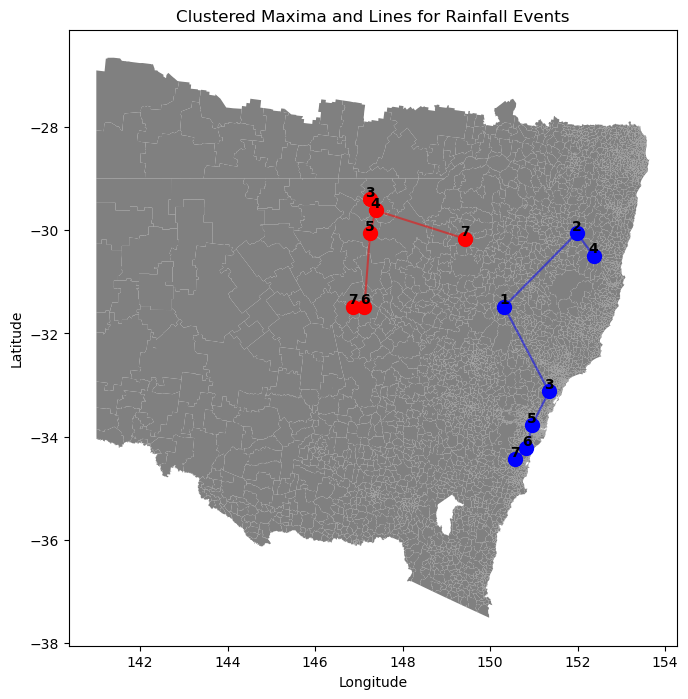

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Function to determine the direction category
def categorize_direction(angle):
    if -15 <= angle <= 15:
        return 'East-West'
    elif 15 < angle <= 75:
        return 'North-east to South-west'
    elif 75 < angle <= 105:
        return 'North-South'
    elif 105 < angle <= 165:
        return 'North-west to South-east'
    elif angle > 165 or angle <= -165:
        return 'West-East'
    elif -75 <= angle < -15:
        return 'South-east to North-west'
    elif -105 <= angle < -75:
        return 'South-North'
    elif -165 <= angle < -105:
        return 'South-west to North-east'
    else:
        return 'Undefined'

# Function to reverse the direction
def reverse_direction(direction):
    reverse_map = {
        'East-West': 'West-East',
        'West-East': 'East-West',
        'North-east to South-west': 'South-west to North-east',
        'South-west to North-east': 'North-east to South-west',
        'North-west to South-east': 'South-east to North-west',
        'South-east to North-west': 'North-west to South-east',
        'North-South': 'South-North',
        'South-North': 'North-South'
    }
    return reverse_map.get(direction, 'Undefined')

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 50 - 1890-02-16 to 1890-02-22.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Combine global and filtered local maxima coordinates for clustering
all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

# Perform K-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(all_maxima_coords)

# Initialize dictionaries to store points for each cluster
clusters = {0: [], 1: []}

# Sort points into their respective clusters
for label, point in zip(cluster_labels, all_maxima_coords):
    clusters[label].append(point)

# Function to compute weighted direction from points in each cluster
def compute_weighted_direction(cluster_points):
    if len(cluster_points) < 2:
        return 'Undefined'
    
    # Compute centroid of the points
    centroid = np.mean(cluster_points, axis=0)
    
    # Initialize variables for weighted direction calculation
    weighted_dx = 0
    weighted_dy = 0
    total_weight = 0
    
    # Iterate through points to calculate weighted direction
    for point in cluster_points:
        dx = point[0] - centroid[0]
        dy = point[1] - centroid[1]
        distance = np.sqrt(dx**2 + dy**2)  # Euclidean distance
        weight = 1 / distance  # Inverse distance as weight
        weighted_dx += dx * weight
        weighted_dy += dy * weight
        total_weight += weight
    
    # Calculate weighted average direction
    weighted_angle = np.degrees(np.arctan2(weighted_dy, weighted_dx))
    weighted_direction = categorize_direction(weighted_angle)
    
    return weighted_direction

# Determine the overall direction for each cluster using weighted approach
overall_directions_weighted = {}

for cluster_idx in clusters:
    cluster_points = clusters[cluster_idx]
    weighted_direction = compute_weighted_direction(cluster_points)
    overall_directions_weighted[cluster_idx] = weighted_direction

# Print the weighted direction for each cluster
for cluster_idx, direction in overall_directions_weighted.items():
    print(f'Cluster {cluster_idx + 1} weighted direction: {direction}')

# Plotting code continues here
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='gray', edgecolor='none')

# Function to connect points within each cluster using Minimum Spanning Tree
def connect_points_within_cluster(points, ax, color):
    if len(points) < 2:
        return
    # Compute the distance matrix
    distance_matrix = cdist(points, points)
    # Compute the MST using the distance matrix
    mst = minimum_spanning_tree(distance_matrix).toarray()
    # Plot the MST
    for i in range(len(points)):
        for j in range(len(points)):
            if mst[i, j] > 0:
                ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

# Plot points and lines for each cluster
for cluster_idx in clusters:
    cluster_points = clusters[cluster_idx]
    
    # Plot points
    if cluster_idx == 0:
        color = 'red'
    else:
        color = 'blue'
    
    for x, y in cluster_points:
        ax.plot(x, y, marker='o', color=color, markersize=10)
    
    # Connect points within the cluster using MST
    connect_points_within_cluster(cluster_points, ax, color)

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clustered Maxima and Lines for Rainfall Events')

plt.show()


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_8882/3797957264.py:7: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter


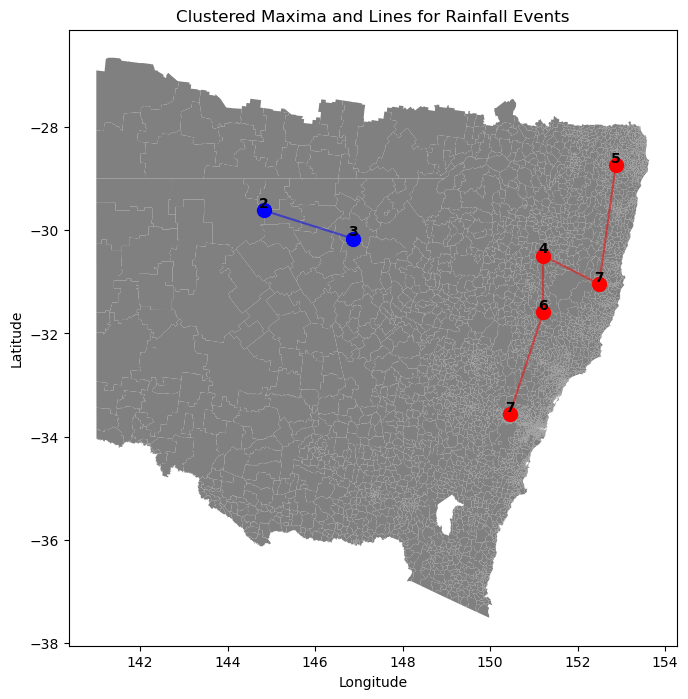

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.spatial import KDTree
from scipy.sparse.csgraph import minimum_spanning_tree

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 2 - 1890-01-10 to 1890-01-16.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Combine global and filtered local maxima coordinates for clustering
all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

# Perform K-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(all_maxima_coords)

# Initialize dictionaries to store points for each cluster
clusters = {0: [], 1: []}

# Sort points into their respective clusters
for label, point in zip(cluster_labels, all_maxima_coords):
    clusters[label].append(point)

# Plotting code continues here
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='gray', edgecolor='none')

# Function to connect points within each cluster using Minimum Spanning Tree
def connect_points_within_cluster(points, ax, color):
    if len(points) < 2:
        return
    # Compute the distance matrix
    distance_matrix = cdist(points, points)
    # Compute the MST using the distance matrix
    mst = minimum_spanning_tree(distance_matrix).toarray()
    # Plot the MST
    for i in range(len(points)):
        for j in range(len(points)):
            if mst[i, j] > 0:
                ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

# Plot points and lines for each cluster
for cluster_idx in clusters:
    cluster_points = clusters[cluster_idx]
    
    # Plot points
    if cluster_idx == 0:
        color = 'red'
    else:
        color = 'blue'
    
    for x, y in cluster_points:
        ax.plot(x, y, marker='o', color=color, markersize=10)
    
    # Connect points within the cluster using MST
    connect_points_within_cluster(cluster_points, ax, color)

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clustered Maxima and Lines for Rainfall Events')

plt.show()


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_8882/2347411583.py:7: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter


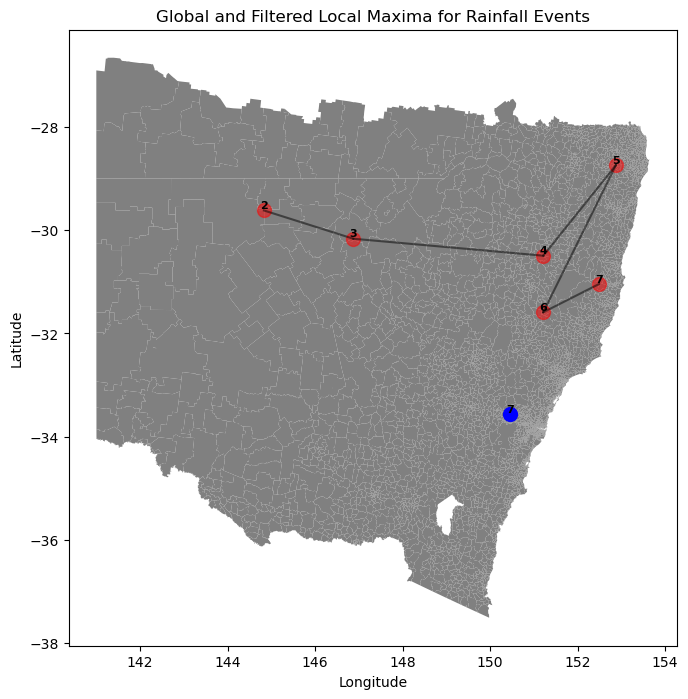

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 2 - 1890-01-10 to 1890-01-16.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Plot only remaining maxima on a single map
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='gray', edgecolor='none')

# Plot global maxima
for idx, (x, y) in enumerate(global_maxima_coords, start=1):
    ax.plot(x, y, marker='o', color='red', markersize=10, linestyle='-', alpha=0.5, label=f'{idx}')

# Plot filtered local maxima
for idx, (x, y) in enumerate(filtered_maxima_coords, start=1):
    ax.plot(x, y, marker='o', color='blue', markersize=10, label=f'{idx}')

# Plot lines connecting global maxima
for i in range(len(global_maxima_coords) - 1):
    x1, y1 = global_maxima_coords[i]
    x2, y2 = global_maxima_coords[i + 1]
    ax.plot([x1, x2], [y1, y2], linestyle='-', color='black', alpha=0.5)

# Plot lines connecting filtered local maxima
for i in range(len(filtered_maxima_coords) - 1):
    x1, y1 = filtered_maxima_coords[i]
    x2, y2 = filtered_maxima_coords[i + 1]
    ax.plot([x1, x2], [y1, y2], linestyle='-', color='green', alpha=0.5)

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=8, ha='center', va='bottom', color='black', weight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Global and Filtered Local Maxima for Rainfall Events')

plt.show()

/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_8882/459053350.py:7: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter


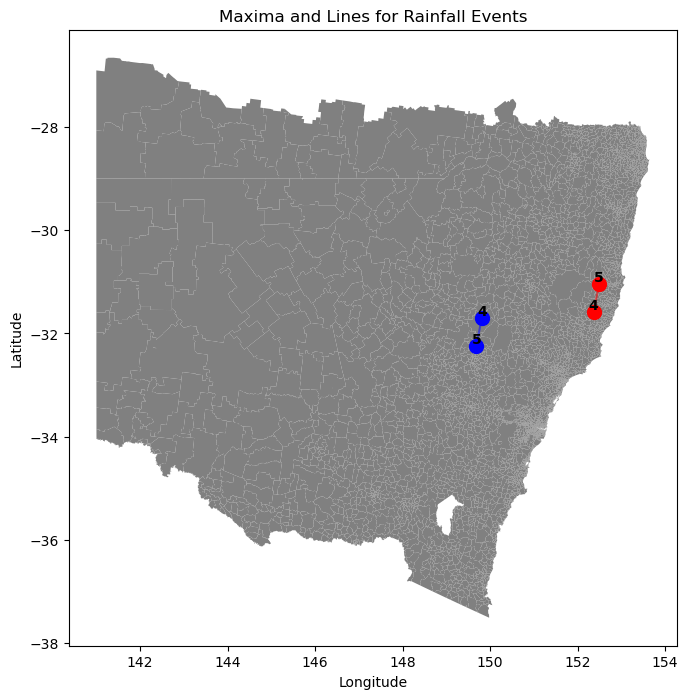

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.metrics import silhouette_score

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 54 - 1898-06-18 to 1898-06-24.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Combine global and filtered local maxima coordinates
all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

# Check if clustering is needed based on the number of points found
if len(all_maxima_coords) > 1:
    # Perform K-means clustering with 2 clusters as a default
    kmeans = KMeans(n_clusters=2, random_state=0)
    cluster_labels = kmeans.fit_predict(all_maxima_coords)

    # Initialize dictionaries to store points for each cluster
    clusters = {label: [] for label in set(cluster_labels)}

    # Sort points into their respective clusters
    for label, point in zip(cluster_labels, all_maxima_coords):
        clusters[label].append(point)

    # Plotting code continues here...
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='gray', edgecolor='none')

    # Function to connect points within each cluster using Minimum Spanning Tree
    def connect_points_within_cluster(points, ax, color):
        if len(points) < 2:
            return
        # Compute the distance matrix
        distance_matrix = cdist(points, points)
        # Compute the MST using the distance matrix
        mst = minimum_spanning_tree(distance_matrix).toarray()
        # Plot the MST
        for i in range(len(points)):
            for j in range(len(points)):
                if mst[i, j] > 0:
                    ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

    # Plot points and lines for each cluster
    for label in clusters:
        cluster_points = clusters[label]

        # Plot points
        if label == 0:
            color = 'red'
        else:
            color = 'blue'

        for x, y in cluster_points:
            ax.plot(x, y, marker='o', color=color, markersize=10)

        # Connect points within the cluster using MST
        connect_points_within_cluster(cluster_points, ax, color)

else:
    # If no meaningful clusters are found, plot the maxima without clustering
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='gray', edgecolor='none')

    # Plot points for maxima
    for x, y in all_maxima_coords:
        ax.plot(x, y, marker='o', color='blue', markersize=10)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Maxima and Lines for Rainfall Events')

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

plt.show()


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_8882/1390074951.py:7: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter


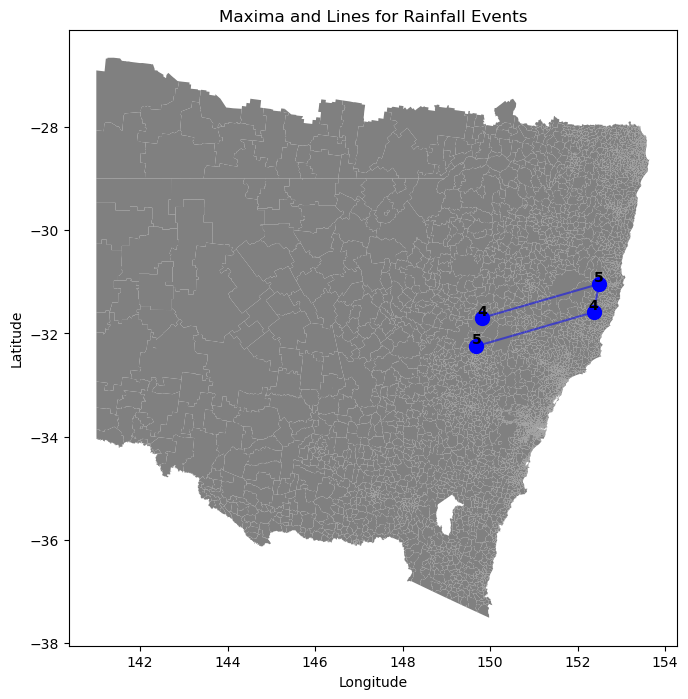

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 54 - 1898-06-18 to 1898-06-24.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Combine global and filtered local maxima coordinates
all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

# Check if clustering is needed based on the number of points found
if len(all_maxima_coords) > 1:
    # Calculate pairwise distances between all maxima points
    distance_matrix = cdist(all_maxima_coords, all_maxima_coords)
    np.fill_diagonal(distance_matrix, np.inf)  # Ignore zero distances to self

    # Check if any pair of points is further apart than the threshold
    max_distance = np.min(distance_matrix)
    if max_distance > distance_threshold:
        # Perform K-means clustering with 2 clusters as a default
        kmeans = KMeans(n_clusters=2, random_state=0)
        cluster_labels = kmeans.fit_predict(all_maxima_coords)

        # Initialize dictionaries to store points for each cluster
        clusters = {label: [] for label in set(cluster_labels)}

        # Sort points into their respective clusters
        for label, point in zip(cluster_labels, all_maxima_coords):
            clusters[label].append(point)

        # Plotting code continues here...
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf.plot(ax=ax, color='gray', edgecolor='none')

        # Function to connect points within each cluster using Minimum Spanning Tree
        def connect_points_within_cluster(points, ax, color):
            if len(points) < 2:
                return
            # Compute the distance matrix
            distance_matrix = cdist(points, points)
            # Compute the MST using the distance matrix
            mst = minimum_spanning_tree(distance_matrix).toarray()
            print("MST:\n", mst)
            print("Points:\n", points)
            # Plot the MST
            for i in range(len(points)):
                for j in range(len(points)):
                    if mst[i, j] > 0:
                        ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

        # Plot points and lines for each cluster
        for label in clusters:
            cluster_points = clusters[label]

            # Plot points
            if label == 0:
                color = 'red'
            else:
                color = 'blue'

            for x, y in cluster_points:
                ax.plot(x, y, marker='o', color=color, markersize=10)

            # Connect points within the cluster using MST
            connect_points_within_cluster(cluster_points, ax, color)

    else:
    # If no meaningful clusters are found, plot the maxima without clustering
     fig, ax = plt.subplots(figsize=(10, 8))
     gdf.plot(ax=ax, color='gray', edgecolor='none')

    # Plot points for maxima and connect them with lines
    for i, (x, y) in enumerate(all_maxima_coords):
        ax.plot(x, y, marker='o', color='blue', markersize=10)
        if i > 0:
            ax.plot([all_maxima_coords[i-1][0], x], [all_maxima_coords[i-1][1], y], linestyle='-', color='blue', alpha=0.5)
else:
    # If there's only one maxima point, just plot it
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='gray', edgecolor='none')
    for x, y in all_maxima_coords:
        ax.plot(x, y, marker='o', color='blue', markersize=10)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Maxima and Lines for Rainfall Events')

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

plt.show()


/var/folders/1_/_3k8kb7n5vz43s2kfx69bp0c0000gn/T/ipykernel_8882/3308595172.py:7: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter


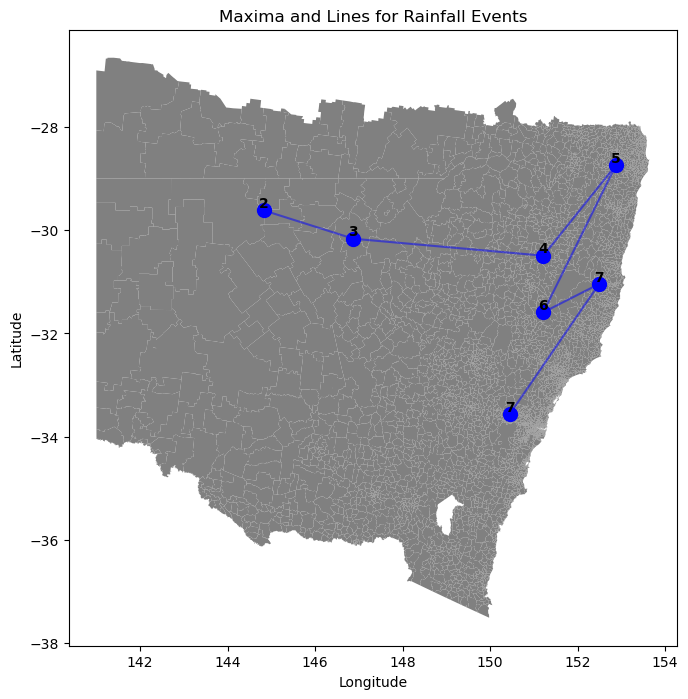

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 2 - 1890-01-10 to 1890-01-16.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Combine global and filtered local maxima coordinates
all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

# Check if clustering is needed based on the number of points found
if len(all_maxima_coords) > 1:
    # Calculate pairwise distances between all maxima points
    distance_matrix = cdist(all_maxima_coords, all_maxima_coords)
    np.fill_diagonal(distance_matrix, np.inf)  # Ignore zero distances to self

    # Check if any pair of points is further apart than the threshold
    max_distance = np.min(distance_matrix)
    if max_distance > distance_threshold:
        # Perform K-means clustering with 2 clusters as a default
        kmeans = KMeans(n_clusters=2, random_state=0)
        cluster_labels = kmeans.fit_predict(all_maxima_coords)

        # Initialize dictionaries to store points for each cluster
        clusters = {label: [] for label in set(cluster_labels)}

        # Sort points into their respective clusters
        for label, point in zip(cluster_labels, all_maxima_coords):
            clusters[label].append(point)

        # Plotting code continues here...
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf.plot(ax=ax, color='gray', edgecolor='none')

        # Function to connect points within each cluster using Minimum Spanning Tree
        def connect_points_within_cluster(points, ax, color):
            if len(points) < 2:
                return
            # Compute the distance matrix
            distance_matrix = cdist(points, points)
            # Compute the MST using the distance matrix
            mst = minimum_spanning_tree(distance_matrix).toarray()
            print("MST:\n", mst)
            print("Points:\n", points)
            # Plot the MST
            for i in range(len(points)):
                for j in range(len(points)):
                    if mst[i, j] > 0:
                        ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

        # Plot points and lines for each cluster
        for label in clusters:
            cluster_points = clusters[label]

            # Plot points
            if label == 0:
                color = 'red'
            else:
                color = 'blue'

            for x, y in cluster_points:
                ax.plot(x, y, marker='o', color=color, markersize=10)

            # Connect points within the cluster using MST
            connect_points_within_cluster(cluster_points, ax, color)

    else:
    # If no meaningful clusters are found, plot the maxima without clustering
     fig, ax = plt.subplots(figsize=(10, 8))
     gdf.plot(ax=ax, color='gray', edgecolor='none')

    # Plot points for maxima and connect them with lines
    for i, (x, y) in enumerate(all_maxima_coords):
        ax.plot(x, y, marker='o', color='blue', markersize=10)
        if i > 0:
            ax.plot([all_maxima_coords[i-1][0], x], [all_maxima_coords[i-1][1], y], linestyle='-', color='blue', alpha=0.5)
else:
    # If there's only one maxima point, just plot it
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='gray', edgecolor='none')
    for x, y in all_maxima_coords:
        ax.plot(x, y, marker='o', color='blue', markersize=10)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Maxima and Lines for Rainfall Events')

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

plt.show()


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Load the CSV file
csv_file = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/Event 50 - 1890-02-16 to 1890-02-22.csv'
df = pd.read_csv(csv_file)

# Filter out NaN values in latitude and longitude
x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

# Read the shapefile
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))

# Flatten the grid to pass into the KDE function
positions = np.vstack([xi.ravel(), yi.ravel()])

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Initialize lists to store coordinates of maxima and their annotations
global_maxima_coords = []
filtered_maxima_coords = []
annotations = []

# Iterate through each rainfall column and generate plots
rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

for idx, col in enumerate(rainfall_columns, start=1):
    rainfall = x_cleaned[col]

    # Perform Gaussian KDE on the rainfall data
    values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
    kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
    zi = kde(positions).reshape(xi.shape)

    # Mask the grid to include only points inside the shapefile geometry
    points = np.vstack((xi.flatten(), yi.flatten())).T
    mask = np.array([gdf.contains(Point(point)).any() for point in points])
    mask = mask.reshape(xi.shape)
    zi = np.where(mask, zi, np.nan)

    # Find global maximum
    global_max_value = np.nanmax(zi)
    global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
    global_max_x = xi[global_max_index]
    global_max_y = yi[global_max_index]

    # Find local maxima (peaks)
    local_max = maximum_filter(zi, size=10) == zi
    peaks = np.where(local_max, zi, np.nan)

    # Calculate 50th percentile value of global maximum
    percentile_90 = 0.5 * global_max_value

    # Remove peaks not within 90th percentile of global maximum
    peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

    # Calculate distances from global maximum to each local maximum
    local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
    global_max_coords = np.array([[global_max_x, global_max_y]])
    distances = cdist(global_max_coords, local_max_coords)[0]

    # Apply distance threshold to filter out local maxima too close to the global maximum
    valid_indices = distances > distance_threshold
    filtered_peaks_coords = local_max_coords[valid_indices]
    filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

    # Find mean rainfall value at the global maximum
    global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

    # Check if global maxima exceeds 25.00 mm threshold
    if global_max_rainfall_mean >= 25.00:
        # Store coordinates of global maxima for plotting lines
        global_maxima_coords.append((global_max_x, global_max_y))

        # Prepare annotations for global maximum
        annotations.append((global_max_x, global_max_y, f'{idx}'))

        # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))
    else:
        # If global maxima don't exceed threshold, but some local maxima do, plot those
        for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
            local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
            if local_max_rainfall_mean >= 25.0:
                filtered_maxima_coords.append((x, y))
                annotations.append((x, y, f'{idx}'))

# Combine global and filtered local maxima coordinates
all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

# Divide the map into longitude sections and count points in each section
long_sections = [140, 144, 148,152]  # Define longitude section boundaries
section_counts = [0] * (len(long_sections) - 1)

print("All maxima coordinates:", all_maxima_coords)  # Debug print

for lon, lat in all_maxima_coords:
    for i in range(len(long_sections) - 1):
        if long_sections[i] <= lon < long_sections[i + 1]:
            section_counts[i] += 1

print("Section counts:", section_counts)  # Debug print
# Define the threshold for the number of points in each section
point_threshold = 2

# Check if at least two sections satisfy the criteria
satisfying_sections = sum(count > point_threshold for count in section_counts)
perform_clustering = satisfying_sections >= 2


if perform_clustering:
    # Perform K-means clustering with 2 clusters as a default
    kmeans = KMeans(n_clusters=2, random_state=0)
    cluster_labels = kmeans.fit_predict(all_maxima_coords)

    # Initialize dictionaries to store points for each cluster
    clusters = {label: [] for label in set(cluster_labels)}

    # Sort points into their respective clusters
    for label, point in zip(cluster_labels, all_maxima_coords):
        clusters[label].append(point)

    # Plotting code continues here...
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='gray', edgecolor='none')

   

    # Plot points and lines for each cluster
    for label in clusters:
        cluster_points = clusters[label]

        # Plot points
        if label == 0:
            color = 'red'
        else:
            color = 'blue'

        for x, y in cluster_points:
            ax.plot(x, y, marker='o', color=color, markersize=10)

        # Connect points within the cluster using MST
        connect_points_within_cluster(cluster_points, ax, color)

else:
    # If no meaningful clusters are found, plot the maxima without clustering
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='gray', edgecolor='none')

    # Plot points for maxima and connect them with lines
    for i, (x, y) in enumerate(all_maxima_coords):
        ax.plot(x, y, marker='o', color='blue', markersize=10)
        if i > 0:
            ax.plot([all_maxima_coords[i-1][0], x], [all_maxima_coords[i-1][1], y], linestyle='-', color='blue', alpha=0.5)

# If there's only one maxima point, just plot it
if len(all_maxima_coords) == 1:
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(ax=ax, color='gray', edgecolor='none')
    for x, y in all_maxima_coords:
        ax.plot(x, y, marker='o', color='blue', markersize=10)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Maxima and Lines for Rainfall Events')

# Annotate points with numbers
for x, y, label in annotations:
    ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

plt.show()

IndentationError: unindent does not match any outer indentation level (<string>, line 165)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.ndimage.filters import maximum_filter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
import os

# Define paths
excel_file_path = '/Users/coolkarni/Desktop/OneDrive - The University of Melbourne/R1_99_New Events.xlsx'
csv_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/'
output_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Map_KDE_2Plots/'

# Load event names from the Excel file, skipping NaN values
event_df = pd.read_excel(excel_file_path,sheet_name='Sheet4')
event_names = event_df['Event'].dropna().unique()

# Initialize a list to store names of files that encountered errors
error_files = []

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Process each event
for event_name in event_names:
    # Construct the path to the corresponding CSV file
    csv_file = os.path.join(csv_directory, f"{event_name}.csv")
    
    try:
        # Load the CSV file
        df = pd.read_csv(csv_file)

        # Filter out NaN values in latitude and longitude
        x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

        # Read the shapefile (assuming you have this in your directory)
        shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
        gdf = gpd.read_file(shapefile_path)

        # Create a grid of points within the bounds of the shapefile
        minx, miny, maxx, maxy = gdf.total_bounds
        xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))
        positions = np.vstack([xi.ravel(), yi.ravel()])

        # Initialize lists to store coordinates of maxima and their annotations
        global_maxima_coords = []
        filtered_maxima_coords = []
        annotations = []

        # Iterate through each rainfall column and generate plots
        rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

        for idx, col in enumerate(rainfall_columns, start=1):
            rainfall = x_cleaned[col]

            # Perform Gaussian KDE on the rainfall data
            values = np.vstack([x_cleaned['Longitude'], x_cleaned['Latitude']])
            kde = gaussian_kde(values, weights=rainfall, bw_method='scott')
            zi = kde(positions).reshape(xi.shape)

            # Mask the grid to include only points inside the shapefile geometry
            points = np.vstack((xi.flatten(), yi.flatten())).T
            mask = np.array([gdf.contains(Point(point)).any() for point in points])
            mask = mask.reshape(xi.shape)
            zi = np.where(mask, zi, np.nan)

            # Find global maximum
            global_max_value = np.nanmax(zi)
            global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
            global_max_x = xi[global_max_index]
            global_max_y = yi[global_max_index]

            # Find local maxima (peaks)
            local_max = maximum_filter(zi, size=10) == zi
            peaks = np.where(local_max, zi, np.nan)

            # Calculate 50th percentile value of global maximum
            percentile_90 = 0.5 * global_max_value

            # Remove peaks not within 90th percentile of global maximum
            peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

            # Calculate distances from global maximum to each local maximum
            local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
            global_max_coords = np.array([[global_max_x, global_max_y]])
            
            # Check if there are any local maxima
            if local_max_coords.shape[0] > 0:
               # Calculate distances from global maximum to each local maximum
               distances = cdist(global_max_coords, local_max_coords)[0]

               # Apply distance threshold to filter out local maxima too close to the global maximum
               valid_indices = distances > distance_threshold
               filtered_peaks_coords = local_max_coords[valid_indices]
               filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

               # Proceed with processing filtered peaks...
               for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                         filtered_maxima_coords.append((x, y))
                         annotations.append((x, y, f'{idx}'))
            else:
              # No local maxima found, skip this chunk
              print("No local maxima found, skipping filtering.")

            # Find mean rainfall value at the global maximum
            global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

            # Check if global maxima exceeds 25.00 mm threshold
            if global_max_rainfall_mean >= 25.00:
                global_maxima_coords.append((global_max_x, global_max_y))
                annotations.append((global_max_x, global_max_y, f'{idx}'))

                # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
                for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                        filtered_maxima_coords.append((x, y))
                        annotations.append((x, y, f'{idx}'))
            else:
                # If global maxima don't exceed threshold, but some local maxima do, plot those
                for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                        filtered_maxima_coords.append((x, y))
                        annotations.append((x, y, f'{idx}'))

        # Combine global and filtered local maxima coordinates
        all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

        # Define a small deviation threshold (in degrees)
        deviation_threshold = 0.05  # Adjust as needed

        # Divide the map into longitude sections and count points in each section
        long_sections = [140, 144, 148, 154]  # Define longitude section boundaries
        section_counts = [0] * (len(long_sections) - 1)
        
        # Set to store unique points that are counted
        counted_points = set()

        for lon, lat in all_maxima_coords:
           for i in range(len(long_sections) - 1):
            # Check if the point is within the section range
               if long_sections[i] - deviation_threshold < lon < long_sections[i + 1] + deviation_threshold:
                   # Use tuple of coordinates to track unique points
                   counted_points.add((lon, lat))
                   section_counts[i] += 1

        # Check if at least two sections satisfy the criteria
        point_threshold = 1
        satisfying_sections = sum(count > point_threshold for count in section_counts)
        perform_clustering = satisfying_sections >= 2

        if perform_clustering:
            # Perform K-means clustering with 2 clusters as a default
            kmeans = KMeans(n_clusters=2, random_state=0)
            cluster_labels = kmeans.fit_predict(all_maxima_coords)

            # Initialize dictionaries to store points for each cluster
            clusters = {label: [] for label in set(cluster_labels)}

            # Sort points into their respective clusters
            for label, point in zip(cluster_labels, all_maxima_coords):
                clusters[label].append(point)

            # Plotting code
            fig, ax = plt.subplots(figsize=(10, 8))
            gdf.plot(ax=ax, color='gray', edgecolor='none')

            # Function to connect points within each cluster using Minimum Spanning Tree
            def connect_points_within_cluster(points, ax, color):
                if len(points) < 2:
                    return
                # Compute the distance matrix
                distance_matrix = cdist(points, points)
                # Compute the MST using the distance matrix
                mst = minimum_spanning_tree(distance_matrix).toarray()
                # Plot the MST
                for i in range(len(points)):
                    for j in range(len(points)):
                        if mst[i, j] > 0:
                            ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

            # Plot points and lines for each cluster
            for label in clusters:
                cluster_points = clusters[label]

                # Choose a color based on the cluster label
                color = 'red' if label == 0 else 'blue'

                # Plot points
                for x, y in cluster_points:
                    ax.plot(x, y, marker='o', color=color, markersize=10)

                # Connect points within the cluster using MST
                connect_points_within_cluster(cluster_points, ax, color)

        else:
            # If no meaningful clusters are found, plot the maxima without clustering
            fig, ax = plt.subplots(figsize=(10, 8))
            gdf.plot(ax=ax, color='gray', edgecolor='none')

            # Plot points for maxima
            for i, (x, y) in enumerate(all_maxima_coords):
               ax.plot(x, y, marker='o', color='blue', markersize=10)

            # Connect points within the maxima using MST
            connect_points_within_cluster(all_maxima_coords, ax, 'blue')

        # If there's only one maxima point, just plot it
        if len(all_maxima_coords) == 1:
           fig, ax = plt.subplots(figsize=(10, 8))
           gdf.plot(ax=ax, color='gray', edgecolor='none')
           for x, y in all_maxima_coords:
               ax.plot(x, y, marker='o', color='blue', markersize=10)

        # Annotate points with numbers
        for x, y, label in annotations:
            ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

        # Set labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'{event_name}')

        # Save the output plot
        plt.savefig(os.path.join(output_directory, f"{event_name}_output.png"))
        plt.close()

    except Exception as e:
        # Append the event name to the error files list
        error_files.append(event_name)
        print(f"Error processing {event_name}: {e}")

# If there are any error files, save them to the new sheet in the existing Excel file
if error_files:
    # Load the existing data from the specified sheet
    try:
        existing_df = pd.read_excel(excel_file_path, sheet_name='IDW', engine='openpyxl')
    except ValueError:
        # If the sheet doesn't exist, create an empty DataFrame
        existing_df = pd.DataFrame()

    # Create a DataFrame for the new error files
    new_errors_df = pd.DataFrame({'Error Files': error_files})

    # Concatenate the existing data with the new error data
    combined_df = pd.concat([existing_df, new_errors_df], ignore_index=True)

    # Save the combined DataFrame back to the same sheet
    with pd.ExcelWriter(excel_file_path, mode='a', engine='openpyxl') as writer:
        combined_df.to_excel(writer, sheet_name='IDW', index=False)
print("Processing complete. Check the output directory for results and the Excel file for any errors.")


In [ ]:
# Plot points for maxima and connect them with lines
            for i, (x, y) in enumerate(all_maxima_coords):
                ax.plot(x, y, marker='o', color='blue', markersize=10)
                if i > 0:
                    ax.plot([all_maxima_coords[i-1][0], x], [all_maxima_coords[i-1][1], y], linestyle='-', color='blue', alpha=0.5)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter,maximum_filter
from scipy.sparse.csgraph import minimum_spanning_tree
import os

# Define paths
excel_file_path = '/Users/coolkarni/Desktop/OneDrive - The University of Melbourne/R1_99_New Events.xlsx'
csv_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/'
output_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Map_IDW_2Plots/'

# Load event names from the Excel file, skipping NaN values
event_df = pd.read_excel(excel_file_path, sheet_name='Sheet2')
event_names = event_df['Event'].dropna().unique()

# Initialize a list to store names of files that encountered errors
error_files = []

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Function to perform IDW interpolation
def perform_idw(latitude, longitude, rainfall):
    try:
        # Create a grid for interpolation
        xi, yi = np.meshgrid(np.linspace(min(longitude), max(longitude), 100),
                             np.linspace(min(latitude), max(latitude), 100))
        zi = np.zeros_like(xi)

        for i in range(len(xi)):
            for j in range(len(yi)):
                distances = np.sqrt((longitude.values - xi[i, j])**2 + (latitude.values - yi[i, j])**2)
                weights = 1 / (distances + 1e-6)  # Avoid division by zero
                zi[i, j] = np.sum(weights * rainfall.values) / np.sum(weights)

        zi_smoothed = gaussian_filter(zi, sigma=2)
        return zi_smoothed, None
    except Exception as e:
        return None, str(e)

# Function to connect points within each cluster using Minimum Spanning Tree
def connect_points_within_cluster(points, ax, color):
    if len(points) < 2:
        return
    # Compute the distance matrix
    distance_matrix = cdist(points, points)
    # Compute the MST using the distance matrix
    mst = minimum_spanning_tree(distance_matrix).toarray()
    # Plot the MST
    for i in range(len(points)):
        for j in range(len(points)):
            if mst[i, j] > 0:
                ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

# Process each event
for event_name in event_names:
    # Construct the path to the corresponding CSV file
    csv_file = os.path.join(csv_directory, f"{event_name}.csv")
    
    try:
        # Load the CSV file
        df = pd.read_csv(csv_file)

        # Filter out NaN values in latitude and longitude
        x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

        # Read the shapefile (assuming you have this in your directory)
        shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
        gdf = gpd.read_file(shapefile_path)

        # Create a grid of points within the bounds of the shapefile
        minx, miny, maxx, maxy = gdf.total_bounds
        xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))
        positions = np.vstack([xi.ravel(), yi.ravel()])

        # Initialize lists to store coordinates of maxima and their annotations
        global_maxima_coords = []
        filtered_maxima_coords = []
        annotations = []

        # Iterate through each rainfall column and generate plots
        rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

        for idx, col in enumerate(rainfall_columns, start=1):
            rainfall = x_cleaned[col]

            # Perform IDW interpolation
            zi, _ = perform_idw(x_cleaned['Latitude'], x_cleaned['Longitude'], rainfall)

            # Mask the grid to include only points inside the shapefile geometry
            points = np.vstack((xi.flatten(), yi.flatten())).T
            mask = np.array([gdf.contains(Point(point)).any() for point in points])
            mask = mask.reshape(xi.shape)
            zi = np.where(mask, zi, np.nan)

            # Find global maximum
            global_max_value = np.nanmax(zi)
            global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
            global_max_x = xi[global_max_index]
            global_max_y = yi[global_max_index]

            # Find local maxima (peaks)
            local_max = maximum_filter(zi, size=10) == zi
            peaks = np.where(local_max, zi, np.nan)

            # Calculate 50th percentile value of global maximum
            percentile_90 = 0.9 * global_max_value

            # Remove peaks not within 90th percentile of global maximum
            peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

            # Calculate distances from global maximum to each local maximum
            local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
            global_max_coords = np.array([[global_max_x, global_max_y]])
            
            # Check if there are any local maxima
            if local_max_coords.shape[0] > 0:
                # Calculate distances from global maximum to each local maximum
                distances = cdist(global_max_coords, local_max_coords)[0]

                # Apply distance threshold to filter out local maxima too close to the global maximum
                valid_indices = distances > distance_threshold
                filtered_peaks_coords = local_max_coords[valid_indices]
                filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

                # Proceed with processing filtered peaks...
                for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                        filtered_maxima_coords.append((x, y))
                        annotations.append((x, y, f'{idx}'))
            else:
                print("No local maxima found, skipping filtering.")

            # Find mean rainfall value at the global maximum
            global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

            # Check if global maxima exceeds 25.00 mm threshold
            if global_max_rainfall_mean >= 25.00:
                global_maxima_coords.append((global_max_x, global_max_y))
                annotations.append((global_max_x, global_max_y, f'{idx}'))

                # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
                for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                        filtered_maxima_coords.append((x, y))
                        annotations.append((x, y, f'{idx}'))
            else:
                for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                        filtered_maxima_coords.append((x, y))
                        annotations.append((x, y, f'{idx}'))

        # Combine global and filtered local maxima coordinates
        all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

        # Divide the map into longitude sections and count points in each section
        long_sections = [140, 144, 148, 154]  # Define longitude section boundaries
        section_counts = [0] * (len(long_sections) - 1)
        
        # Set to store unique points that are counted
        counted_points = set()

        for lon, lat in all_maxima_coords:
            for i in range(len(long_sections) - 1):
                if long_sections[i] - 0.05 < lon < long_sections[i + 1] + 0.05:
                    counted_points.add((lon, lat))
                    section_counts[i] += 1

        # Check if at least two sections satisfy the criteria
        point_threshold = 1
        satisfying_sections = sum(count > point_threshold for count in section_counts)
        perform_clustering = satisfying_sections >= 2

        if perform_clustering:
            # Perform K-means clustering with 2 clusters as a default
            kmeans = KMeans(n_clusters=2, random_state=0)
            cluster_labels = kmeans.fit_predict(all_maxima_coords)

            # Initialize dictionaries to store points for each cluster
            clusters = {label: [] for label in set(cluster_labels)}

            # Sort points into their respective clusters
            for label, point in zip(cluster_labels, all_maxima_coords):
                clusters[label].append(point)

            # Plotting code
            fig, ax = plt.subplots(figsize=(10, 8))
            gdf.plot(ax=ax, color='gray', edgecolor='none')

            # Connect points within the cluster using MST
            for label in clusters:
                cluster_points = clusters[label]

                # Choose a color based on the cluster label
                color = 'red' if label == 0 else 'blue'

                # Plot points
                for x, y in cluster_points:
                    ax.plot(x, y, marker='o', color=color, markersize=10)

                # Connect points within the cluster using MST
                connect_points_within_cluster(cluster_points, ax, color)

        else:
            # If no meaningful clusters are found, plot the maxima without clustering
            fig, ax = plt.subplots(figsize=(10, 8))
            gdf.plot(ax=ax, color='gray', edgecolor='none')

            # Plot points for maxima
            for i, (x, y) in enumerate(all_maxima_coords):
                ax.plot(x, y, marker='o', color='blue', markersize=10)

            # Connect points within the maxima using MST
            connect_points_within_cluster(all_maxima_coords, ax, 'blue')

        # If there's only one maxima point, just plot it
        if len(all_maxima_coords) == 1:
            fig, ax = plt.subplots(figsize=(10, 8))
            gdf.plot(ax=ax, color='gray', edgecolor='none')
            for x, y in all_maxima_coords:
                ax.plot(x, y, marker='o', color='blue', markersize=10)

        # Annotate points with numbers
        for x, y, label in annotations:
            ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

        # Set labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'{event_name}')

        # Save the output plot
        plt.savefig(os.path.join(output_directory, f"{event_name}_output.png"))
        plt.close()

    except Exception as e:
        # Append the event name to the error files list
        error_files.append(event_name)
        print(f"Error processing {event_name}: {e}")

# If there are any error files, save them to the new sheet in the existing Excel file
if error_files:
    # Load the existing data from the specified sheet
    try:
        existing_df = pd.read_excel(excel_file_path, sheet_name='IDW', engine='openpyxl')
    except ValueError:
        # If the sheet doesn't exist, create an empty DataFrame
        existing_df = pd.DataFrame()

    # Create a DataFrame for the new error files
    new_errors_df = pd.DataFrame({'Error Files': error_files})

    # Concatenate the existing data with the new error data
    combined_df = pd.concat([existing_df, new_errors_df], ignore_index=True)

    # Save the combined DataFrame back to the same sheet
    with pd.ExcelWriter(excel_file_path, mode='a', engine='openpyxl') as writer:
        combined_df.to_excel(writer, sheet_name='IDW', index=False)

print("Processing complete. Check the output directory for results and the Excel file for any errors.")


No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local ma

No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local maxima found, skipping filtering.
No local ma

KeyboardInterrupt: 

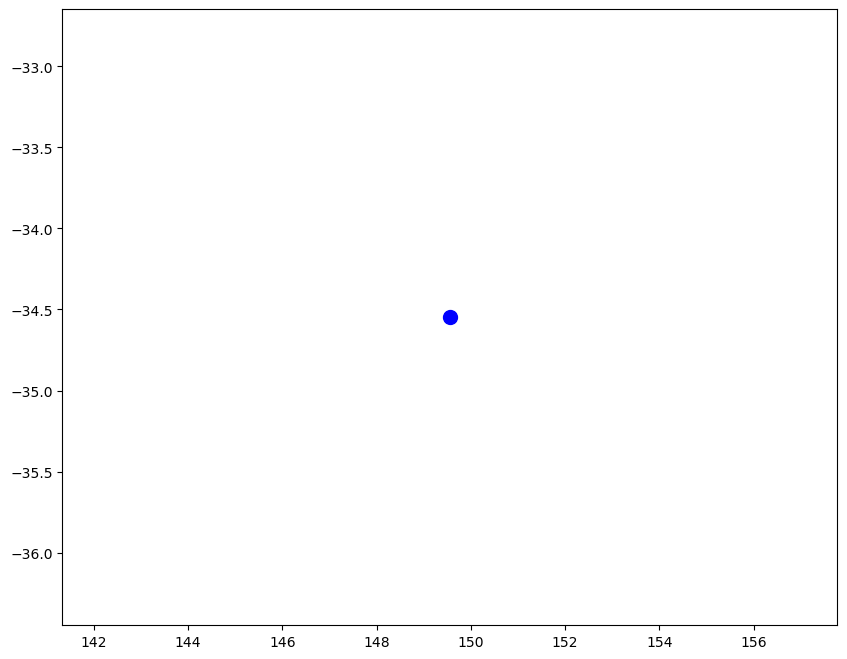

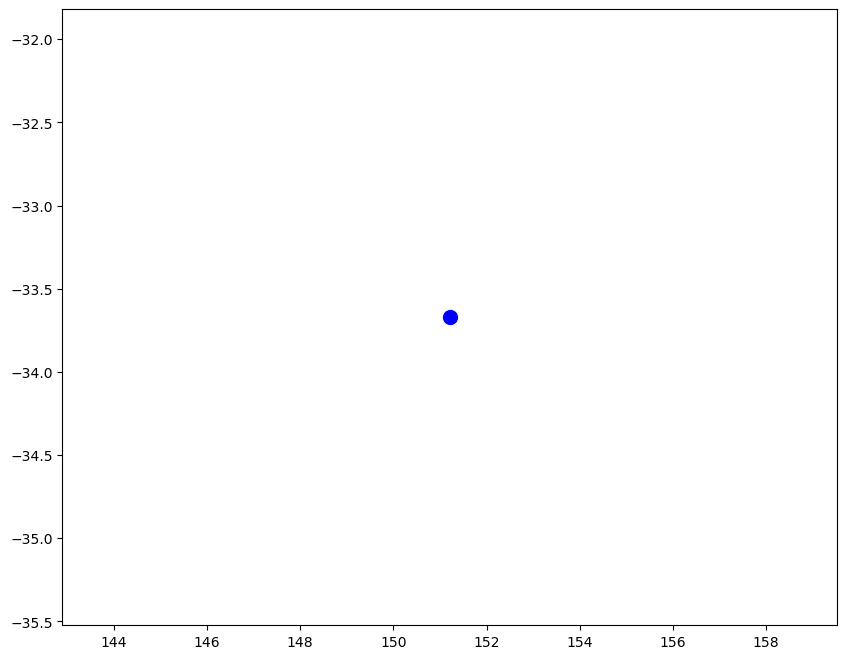

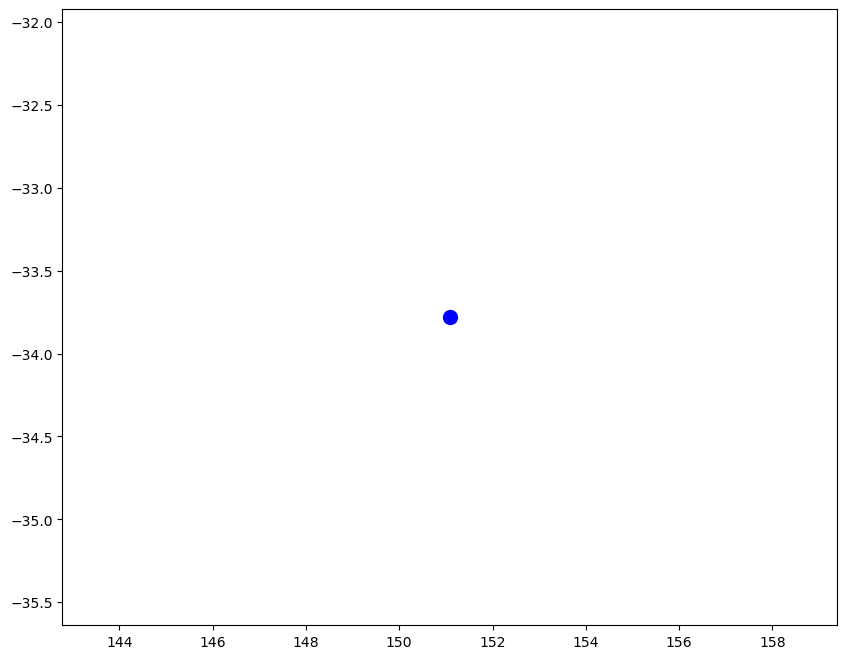

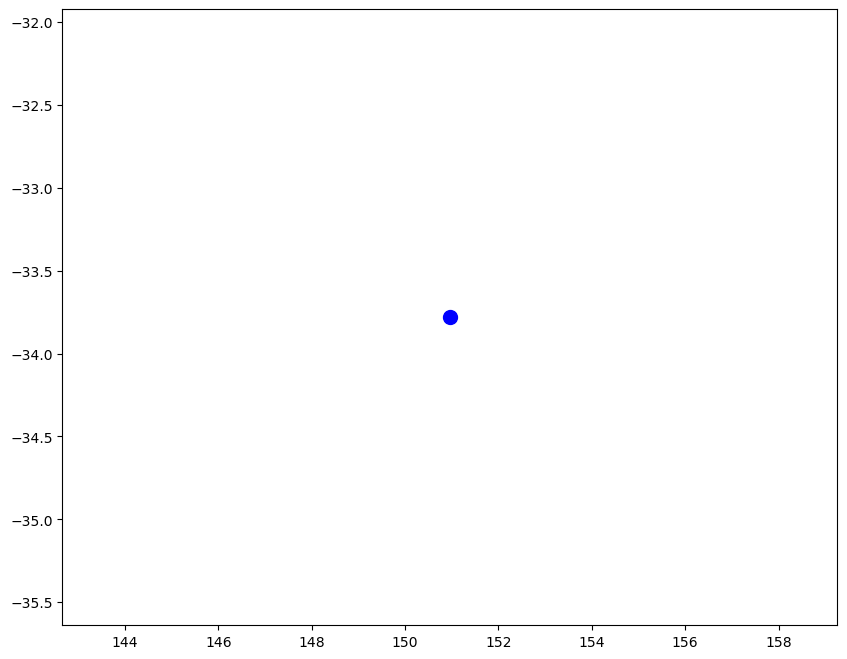

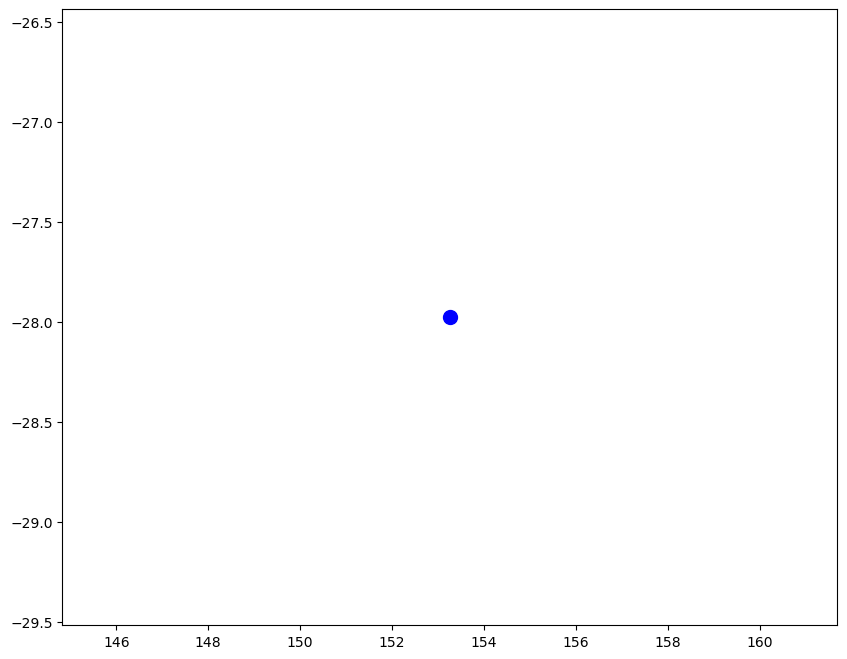

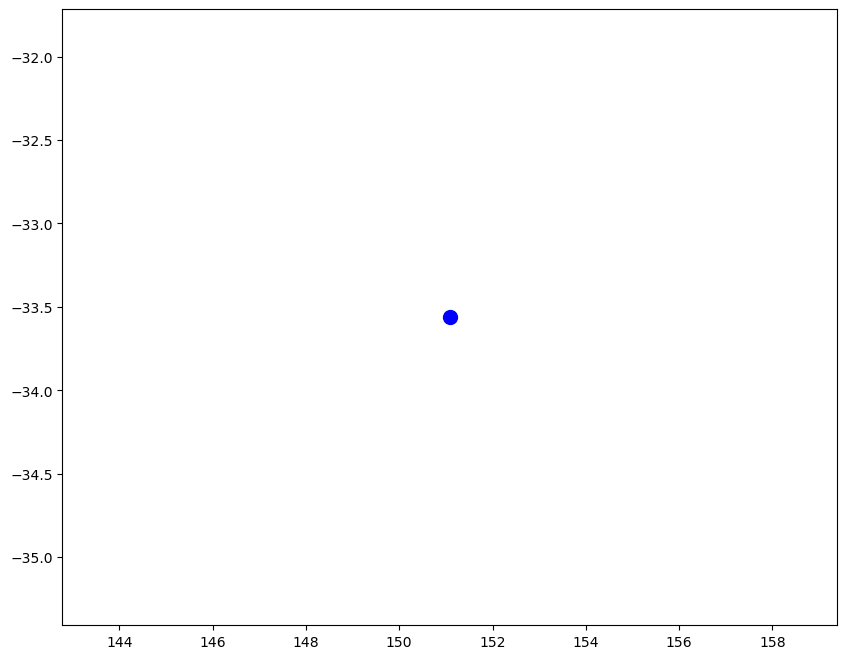

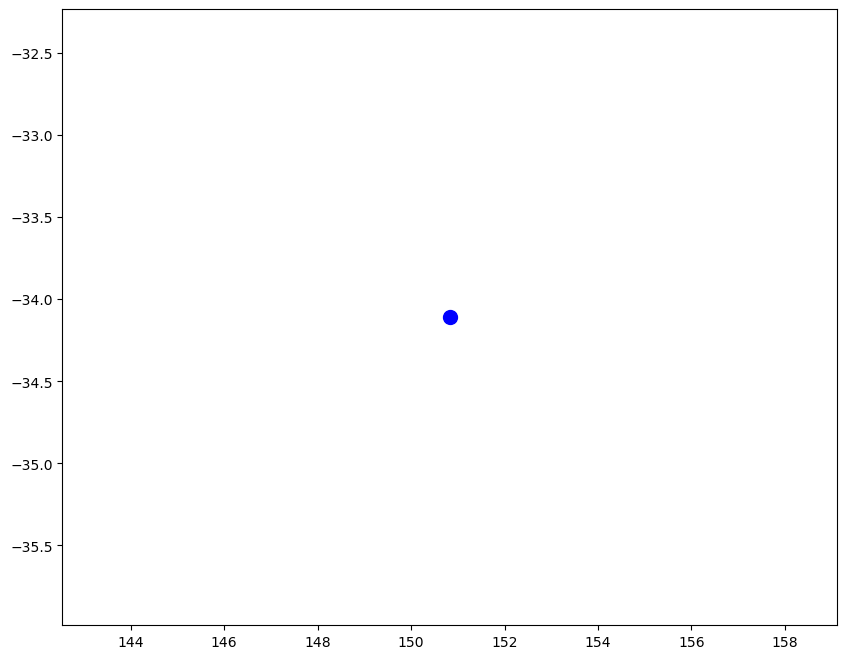

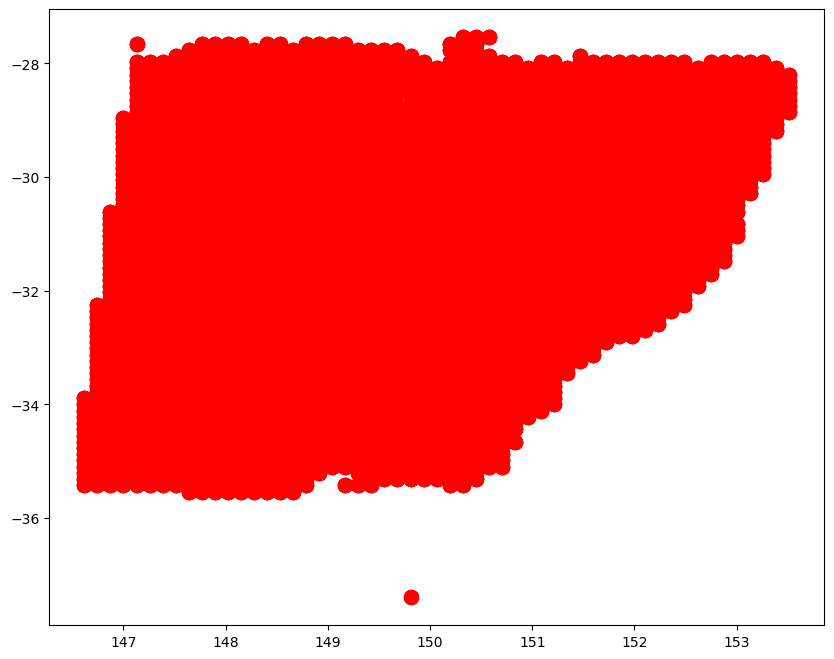

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter,maximum_filter
from scipy.sparse.csgraph import minimum_spanning_tree
import os

# Define paths
excel_file_path = '/Users/coolkarni/Desktop/OneDrive - The University of Melbourne/R1_99_New Events.xlsx'
csv_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events/'
output_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Map_IDW_3Plots/'

# Load event names from the Excel file, skipping NaN values
event_df = pd.read_excel(excel_file_path, sheet_name='Sheet2')
event_names = event_df['Event'].dropna().unique()

# Initialize a list to store names of files that encountered errors
error_files = []

# Set distance threshold (e.g., in degrees, assuming coordinates are in lat/lon)
distance_threshold = 2  # Adjust as needed

# Haversine function to calculate distance between two lat/long coordinates
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to find the mean rainfall value of the 5 nearest stations
def find_nearest_stations_mean_rainfall(df, lon, lat, column):
    df['distance'] = df.apply(lambda row: haversine(lon, lat, row['Longitude'], row['Latitude']), axis=1)
    nearest_stations = df.nsmallest(5, 'distance')
    mean_rainfall = nearest_stations[column].mean()
    return mean_rainfall

# Function to perform IDW interpolation
def perform_idw(latitude, longitude, rainfall):
    try:
        # Create a grid for interpolation
        xi, yi = np.meshgrid(np.linspace(min(longitude), max(longitude), 100),
                             np.linspace(min(latitude), max(latitude), 100))
        zi = np.zeros_like(xi)

        for i in range(len(xi)):
            for j in range(len(yi)):
                distances = np.sqrt((longitude.values - xi[i, j])**2 + (latitude.values - yi[i, j])**2)
                weights = 1 / (distances + 1e-6)  # Avoid division by zero
                zi[i, j] = np.sum(weights * rainfall.values) / np.sum(weights)

        zi_smoothed = gaussian_filter(zi, sigma=2)
        return zi_smoothed, None
    except Exception as e:
        return None, str(e)

# Function to connect points within each cluster using Minimum Spanning Tree
def connect_points_within_cluster(points, ax, color):
    if len(points) < 2:
        return
    # Compute the distance matrix
    distance_matrix = cdist(points, points)
    # Compute the MST using the distance matrix
    mst = minimum_spanning_tree(distance_matrix).toarray()
    # Plot the MST
    for i in range(len(points)):
        for j in range(len(points)):
            if mst[i, j] > 0:
                ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], linestyle='-', color=color, alpha=0.5)

# Process each event
for event_name in event_names:
    # Construct the path to the corresponding CSV file
    csv_file = os.path.join(csv_directory, f"{event_name}.csv")
    
    try:
        # Load the CSV file
        df = pd.read_csv(csv_file)

        # Filter out NaN values in latitude and longitude
        x_cleaned = df[['Latitude', 'Longitude'] + [col for col in df.columns if col.startswith('Rainfall')]].dropna()

        # Read the shapefile (assuming you have this in your directory)
        shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
        gdf = gpd.read_file(shapefile_path)

        # Create a grid of points within the bounds of the shapefile
        minx, miny, maxx, maxy = gdf.total_bounds
        xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))
        positions = np.vstack([xi.ravel(), yi.ravel()])

        # Initialize lists to store coordinates of maxima and their annotations
        global_maxima_coords = []
        filtered_maxima_coords = []
        annotations = []

        # Iterate through each rainfall column and generate plots
        rainfall_columns = [col for col in x_cleaned.columns if col.startswith('Rainfall')]

        for idx, col in enumerate(rainfall_columns, start=1):
            rainfall = x_cleaned[col]

            # Perform IDW interpolation
            zi, _ = perform_idw(x_cleaned['Latitude'], x_cleaned['Longitude'], rainfall)

            # Mask the grid to include only points inside the shapefile geometry
            points = np.vstack((xi.flatten(), yi.flatten())).T
            mask = np.array([gdf.contains(Point(point)).any() for point in points])
            mask = mask.reshape(xi.shape)
            zi = np.where(mask, zi, np.nan)

            # Find global maximum
            global_max_value = np.nanmax(zi)
            global_max_index = np.unravel_index(np.nanargmax(zi), zi.shape)
            global_max_x = xi[global_max_index]
            global_max_y = yi[global_max_index]

            # Find local maxima (peaks)
            local_max = maximum_filter(zi, size=10) == zi
            peaks = np.where(local_max, zi, np.nan)

            # Calculate 50th percentile value of global maximum
            percentile_90 = 0.9 * global_max_value

            # Remove peaks not within 90th percentile of global maximum
            peaks_filtered = np.where(peaks >= percentile_90, peaks, np.nan)

            # Calculate distances from global maximum to each local maximum
            local_max_coords = np.array(list(zip(xi[np.isfinite(peaks_filtered)], yi[np.isfinite(peaks_filtered)])))
            global_max_coords = np.array([[global_max_x, global_max_y]])
            
            # Check if there are any local maxima
            if local_max_coords.shape[0] > 0:
                # Calculate distances from global maximum to each local maximum
                distances = cdist(global_max_coords, local_max_coords)[0]

                # Apply distance threshold to filter out local maxima too close to the global maximum
                valid_indices = distances > distance_threshold
                filtered_peaks_coords = local_max_coords[valid_indices]
                filtered_peaks_values = peaks_filtered[np.isfinite(peaks_filtered)][valid_indices]

                # Proceed with processing filtered peaks...
                for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                        filtered_maxima_coords.append((x, y))
                        annotations.append((x, y, f'{idx}'))
            else:
                print("No local maxima found, skipping filtering.")

            # Find mean rainfall value at the global maximum
            global_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, global_max_x, global_max_y, col)

            # Check if global maxima exceeds 25.00 mm threshold
            if global_max_rainfall_mean >= 25.00:
                global_maxima_coords.append((global_max_x, global_max_y))
                annotations.append((global_max_x, global_max_y, f'{idx}'))

                # Store filtered local maxima (peaks) that also exceed 25.00 mm threshold
                for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                        filtered_maxima_coords.append((x, y))
                        annotations.append((x, y, f'{idx}'))
            else:
                for i, (x, y) in enumerate(filtered_peaks_coords, start=1):
                    local_max_rainfall_mean = find_nearest_stations_mean_rainfall(x_cleaned, x, y, col)
                    if local_max_rainfall_mean >= 25.0:
                        filtered_maxima_coords.append((x, y))
                        annotations.append((x, y, f'{idx}'))

        # Combine global and filtered local maxima coordinates
        all_maxima_coords = np.array(global_maxima_coords + filtered_maxima_coords)

        # Divide the map into longitude sections and count points in each section
        long_sections = [140, 144, 148, 154]  # Define longitude section boundaries
        section_counts = [0] * (len(long_sections) - 1)
        
        # Set to store unique points that are counted
        counted_points = set()

        for lon, lat in all_maxima_coords:
            for i in range(len(long_sections) - 1):
                if long_sections[i] - 0.05 < lon < long_sections[i + 1] + 0.05:
                    counted_points.add((lon, lat))
                    section_counts[i] += 1

        # Check if at least two sections satisfy the criteria
        point_threshold = 2
        satisfying_sections = sum(count > point_threshold for count in section_counts)
        perform_clustering = satisfying_sections >= 2

        if perform_clustering:
            # Perform K-means clustering with 2 clusters as a default
            kmeans = KMeans(n_clusters=2, random_state=0)
            cluster_labels = kmeans.fit_predict(all_maxima_coords)

            # Initialize dictionaries to store points for each cluster
            clusters = {label: [] for label in set(cluster_labels)}

            # Sort points into their respective clusters
            for label, point in zip(cluster_labels, all_maxima_coords):
                clusters[label].append(point)

            # Plotting code
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Connect points within the cluster using MST
            for label in clusters:
                cluster_points = clusters[label]

                # Choose a color based on the cluster label
                color = 'red' if label == 0 else 'blue'

                # Plot points
                for x, y in cluster_points:
                    ax.plot(x, y, marker='o', color=color, markersize=10)

                # Connect points within the cluster using MST
                connect_points_within_cluster(cluster_points, ax, color)

        else:
            # If no meaningful clusters are found, plot the maxima without clustering
            fig, ax = plt.subplots(figsize=(10, 8))
           

            # Plot points for maxima
            for i, (x, y) in enumerate(all_maxima_coords):
                ax.plot(x, y, marker='o', color='blue', markersize=10)

            # Connect points within the maxima using MST
            connect_points_within_cluster(all_maxima_coords, ax, 'blue')

        # If there's only one maxima point, just plot it
        if len(all_maxima_coords) == 1:
            fig, ax = plt.subplots(figsize=(10, 8))
           
            for x, y in all_maxima_coords:
                ax.plot(x, y, marker='o', color='blue', markersize=10)

        # Annotate points with numbers
        for x, y, label in annotations:
            ax.text(x, y, label, fontsize=10, ha='center', va='bottom', color='black', weight='bold')

        

        # Save the output plot
        plt.savefig(os.path.join(output_directory, f"{event_name}_output.png"))
        plt.close()

    except Exception as e:
        # Append the event name to the error files list
        error_files.append(event_name)
        print(f"Error processing {event_name}: {e}")

# If there are any error files, save them to the new sheet in the existing Excel file
if error_files:
    # Load the existing data from the specified sheet
    try:
        existing_df = pd.read_excel(excel_file_path, sheet_name='IDW', engine='openpyxl')
    except ValueError:
        # If the sheet doesn't exist, create an empty DataFrame
        existing_df = pd.DataFrame()

    # Create a DataFrame for the new error files
    new_errors_df = pd.DataFrame({'Error Files': error_files})

    # Concatenate the existing data with the new error data
    combined_df = pd.concat([existing_df, new_errors_df], ignore_index=True)

    # Save the combined DataFrame back to the same sheet
    with pd.ExcelWriter(excel_file_path, mode='a', engine='openpyxl') as writer:
        combined_df.to_excel(writer, sheet_name='IDW', index=False)

print("Processing complete. Check the output directory for results and the Excel file for any errors.")
